In [1]:
%load_ext watermark
%watermark

2019-06-13T08:56:24+02:00

CPython 3.6.8
IPython 6.2.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.13.0-46-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
plt.rcParams['figure.figsize'] = (14,10)
warnings.filterwarnings('ignore')

In [3]:
df_U_FR = pd.read_pickle('../Data/02.-Creacion-del-DataFrame-df_U_FR.pkl')

df_U_FR.head()

,ds,y
0,2017-05-01,48
1,2017-05-02,2371
2,2017-05-03,2640
3,2017-05-04,2565
4,2017-05-05,1717


In [4]:
len(df_U_FR)

654

In [5]:
missing_dates = pd.date_range(start = '2017-05-01',end = '2019-04-01').difference(df_U_FR['ds'])

missing_dates

DatetimeIndex(['2017-06-24', '2017-12-25', '2018-01-01', '2018-01-06',
               '2018-07-21', '2018-07-22', '2018-07-28', '2018-11-01',
               '2018-11-02', '2018-11-03', '2018-11-04', '2018-11-05',
               '2018-11-06', '2018-11-07', '2018-11-08', '2018-11-09',
               '2018-11-10', '2018-11-11', '2018-11-18', '2018-11-24',
               '2018-11-25', '2018-12-01', '2018-12-02', '2018-12-03',
               '2018-12-04', '2018-12-05', '2018-12-06', '2018-12-07',
               '2018-12-08', '2018-12-09', '2018-12-10', '2018-12-16',
               '2018-12-22', '2018-12-23', '2018-12-25', '2019-01-06',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12'],
              dtype='datetime64[ns]', freq=None)

In [6]:
len(missing_dates)

47

In [7]:
def new_y_for_date(date,df_temp):
    df_monthdays_for_date = df_temp.loc[(df_temp['ds'].dt.year == date.year) &
                                        (df_temp['ds'].dt.month == date.month) &
                                        (df_temp['ds'].dt.weekday == date.weekday())]
    new_y = df_monthdays_for_date['y'].mean()
    if np.isnan(new_y) == False:
        return np.int64(round(new_y))
    else:
        return np.int64(round(df_temp.loc[df_temp['ds'].dt.weekday == date.weekday()]['y'].mean()))

In [8]:
df_missing_dates = pd.DataFrame()

df_missing_dates['ds'] = missing_dates

df_missing_dates['y'] = [new_y_for_date(date,df_U_FR) for date in df_missing_dates['ds']]

df_missing_dates.head()

,ds,y
0,2017-06-24,26
1,2017-12-25,4066
2,2018-01-01,2637
3,2018-01-06,39
4,2018-07-21,52


In [9]:
df_U_FR = df_U_FR.append(df_missing_dates)

df_U_FR['ds'] = pd.to_datetime(df_U_FR['ds'])

df_U_FR = df_U_FR.sort_values(by = 'ds')

df_U_FR = df_U_FR.reset_index(drop = True)

In [10]:
len(pd.date_range(start = '2017-05-01',end = '2019-04-01').difference(df_U_FR['ds']))

0

In [11]:
df_U_FR.head()

,ds,y
0,2017-05-01,48
1,2017-05-02,2371
2,2017-05-03,2640
3,2017-05-04,2565
4,2017-05-05,1717


In [12]:
df_U_FR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 2 columns):
ds    701 non-null datetime64[ns]
y     701 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.0 KB


In [13]:
len(df_U_FR)

701

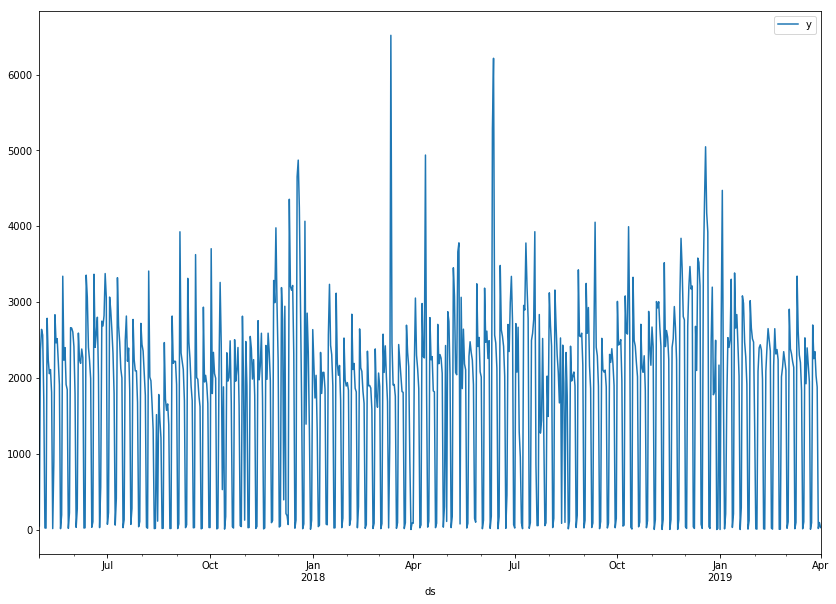

In [14]:
df_U_FR.plot.line(x = 'ds',y = 'y',figsize = (14,10));

In [15]:
df_U_FR.set_index('ds',inplace = True)

df_U_FR.head()

,y
ds,
2017-05-01,48
2017-05-02,2371
2017-05-03,2640
2017-05-04,2565
2017-05-05,1717


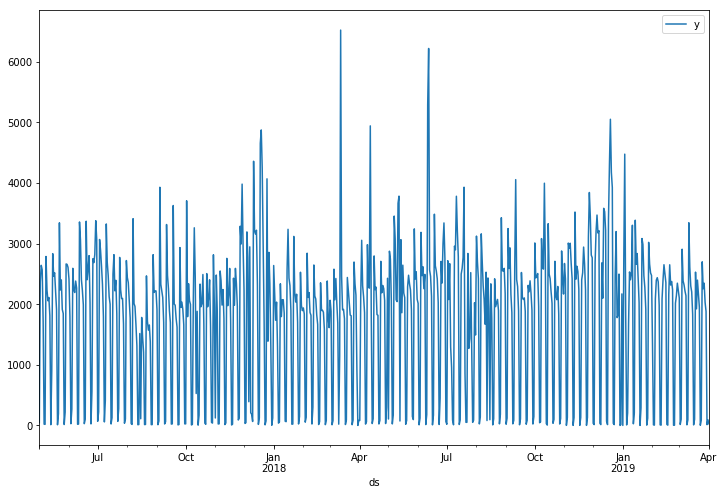

In [16]:
df_U_FR.plot(figsize=(12,8));

## Descomposición de la Serie Temporal: ETS Components 

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

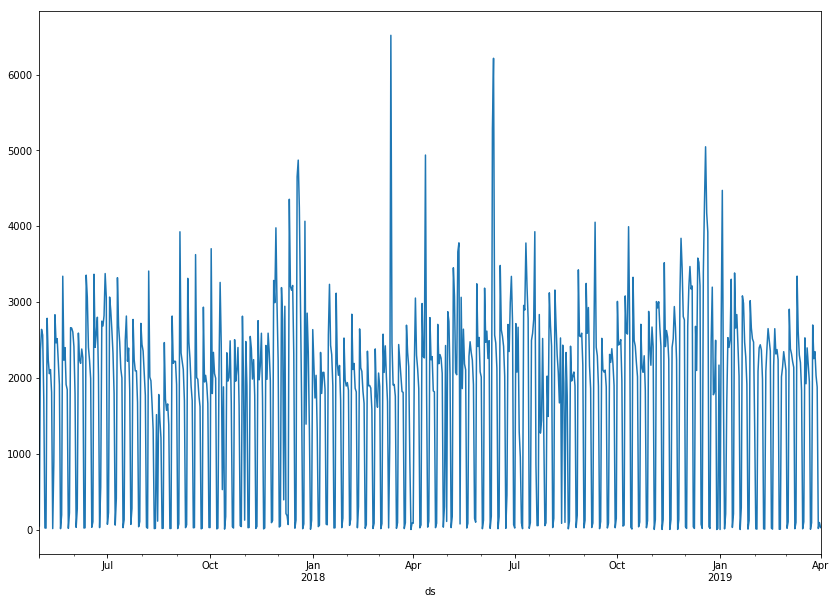

In [18]:
seasonal_decompose(df_U_FR['y']).observed.plot(figsize = (14,10));

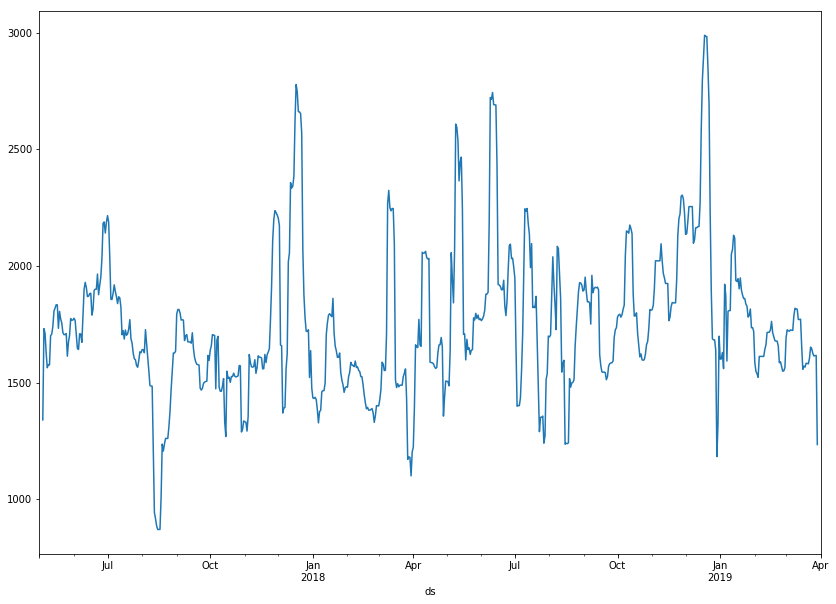

In [19]:
seasonal_decompose(df_U_FR['y']).trend.plot(figsize = (14,10));

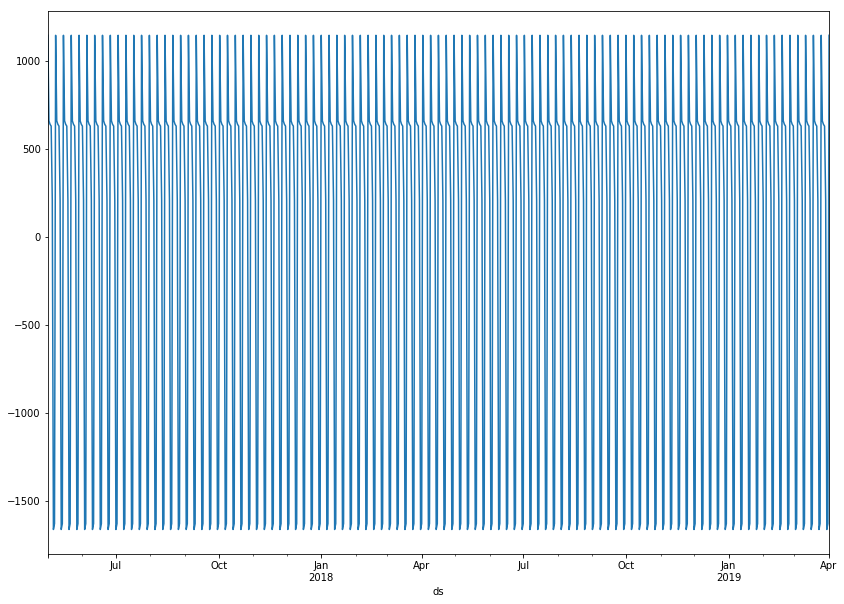

In [20]:
seasonal_decompose(df_U_FR['y']).seasonal.plot(figsize = (14,10));

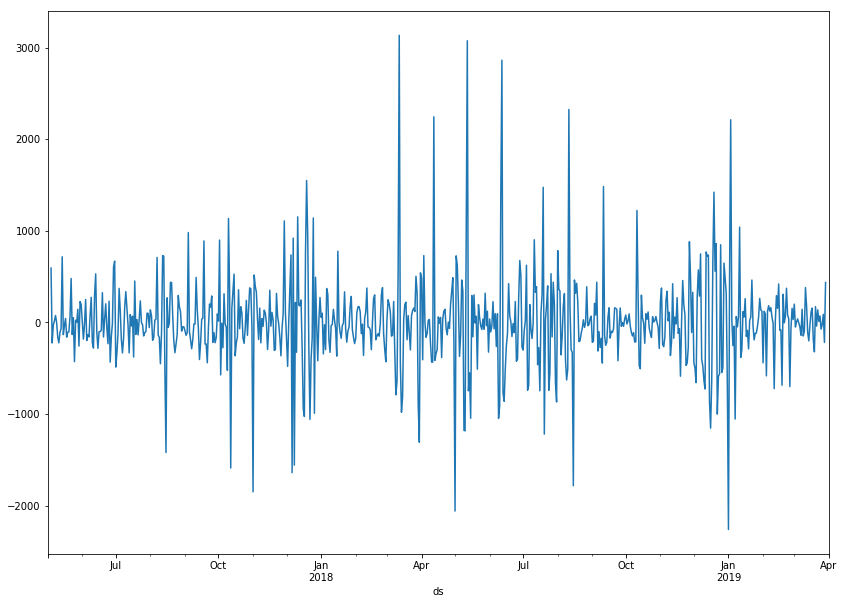

In [21]:
seasonal_decompose(df_U_FR['y']).resid.plot(figsize = (14,10));

## Train Test Split

In [22]:
len(df_U_FR)

701

In [23]:
df_train = df_U_FR.iloc[:641]

df_test = df_U_FR.iloc[641:]

## Scale Data

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler = MinMaxScaler()

In [26]:
scaler.fit(df_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [27]:
scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)

## Create the Model

In [28]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [29]:
n_input = 7
n_features = 1

In [30]:
generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_input,batch_size = 1)

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [32]:
model = Sequential()

In [33]:
model.add(LSTM(150, activation = 'relu',input_shape = (n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam',loss = 'mse')

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit_generator(generator,epochs = 30)

Epoch 1/30
634/634 [==============================] - 33s 52ms/step - loss: 0.0326
Epoch 2/30
634/634 [==============================] - 28s 45ms/step - loss: 0.0164
Epoch 3/30
634/634 [==============================] - 22s 34ms/step - loss: 0.0131
Epoch 4/30
634/634 [==============================] - 22s 34ms/step - loss: 0.0125
Epoch 5/30
634/634 [==============================] - 22s 34ms/step - loss: 0.0124
Epoch 6/30
634/634 [==============================] - 20s 31ms/step - loss: 0.0124
Epoch 7/30
634/634 [==============================] - 24s 38ms/step - loss: 0.0116
Epoch 8/30
634/634 [==============================] - 23s 36ms/step - loss: 0.0114
Epoch 9/30
634/634 [==============================] - 24s 37ms/step - loss: 0.0110
Epoch 10/30
634/634 [==============================] - 24s 38ms/step - loss: 0.0111
Epoch 11/30
634/634 [==============================] - 25s 40ms/step - loss: 0.0106
Epoch 12/30
634/634 [==============================] - 27s 42ms/step - loss: 0.0103
E

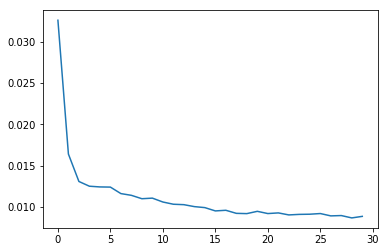

In [37]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

## Evaluate on Test Data

In [38]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(df_test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [39]:
true_predictions = scaler.inverse_transform(test_predictions)

true_predictions

array([[1859.94109091],
       [  23.72374877],
       [  99.70380134],
       [2864.70994636],
       [2395.40788943],
       [2237.71906856],
       [2090.36498043],
       [1689.73798099],
       [  21.90911083],
       [ 154.21130582],
       [2713.5300785 ],
       [2269.63280717],
       [2109.39152426],
       [1951.86507276],
       [1579.12355603],
       [   7.42458794],
       [ 212.88955212],
       [2625.15841219],
       [2197.98207846],
       [2039.60357621],
       [1881.79744542],
       [1501.28288352],
       [  -6.62332449],
       [ 260.95083722],
       [2568.50742808],
       [2158.21595511],
       [2007.34917268],
       [1852.34410775],
       [1454.16255417],
       [ -16.84395196],
       [ 305.53904926],
       [2534.71245775],
       [2134.72755536],
       [1987.02581033],
       [1837.37971151],
       [1419.72422434],
       [ -24.78155149],
       [ 345.11602492],
       [2510.65537676],
       [2117.65818396],
       [1972.23291188],
       [1826.499

In [42]:
df_test['Predictions'] = true_predictions

df_test.head()

,y,Predictions
ds,,
2019-02-01,1355,1859.941091
2019-02-02,11,23.723749
2019-02-03,6,99.703801
2019-02-04,2086,2864.709946
2019-02-05,2396,2395.407889


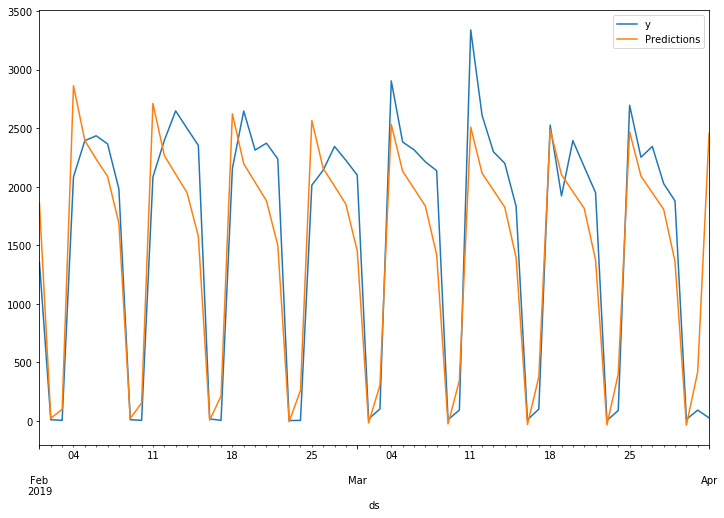

In [45]:
df_test.plot(figsize=(12,8));

In [46]:
df_test.tail()

,y,Predictions
ds,,
2019-03-28,2029,1809.556088
2019-03-29,1880,1362.595649
2019-03-30,14,-36.031894
2019-03-31,93,420.060924
2019-04-01,27,2457.294897


In [48]:
df_test = df_test[df_test.index <= '2019-03-31']

df_test.tail()

,y,Predictions
ds,,
2019-03-27,2346,1950.319845
2019-03-28,2029,1809.556088
2019-03-29,1880,1362.595649
2019-03-30,14,-36.031894
2019-03-31,93,420.060924


In [49]:
from statsmodels.tools.eval_measures import rmse

In [50]:
rmse(df_test['Predictions'],df_test['y'])

391.49740904242594

In [51]:
def mape(y_pred,y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [52]:
mape(df_test['Predictions'],df_test['y'])

297.45834920052

## Pruebas

In [53]:
df_test[df_test['Predictions'] < 0]

,y,Predictions
ds,,
2019-02-23,4,-6.623324
2019-03-02,17,-16.843952
2019-03-09,11,-24.781551
2019-03-16,10,-30.576400
2019-03-23,4,-33.847822
2019-03-30,14,-36.031894


In [59]:
df_test.loc[df_test['Predictions'] < 0,'Predictions'] = 0

In [61]:
len(df_test[df_test['Predictions'] < 0])

0

In [64]:
rmse(df_test['Predictions'],df_test['y'])

391.33756671280094

In [62]:
mape(df_test['Predictions'],df_test['y'])

265.2671248718452

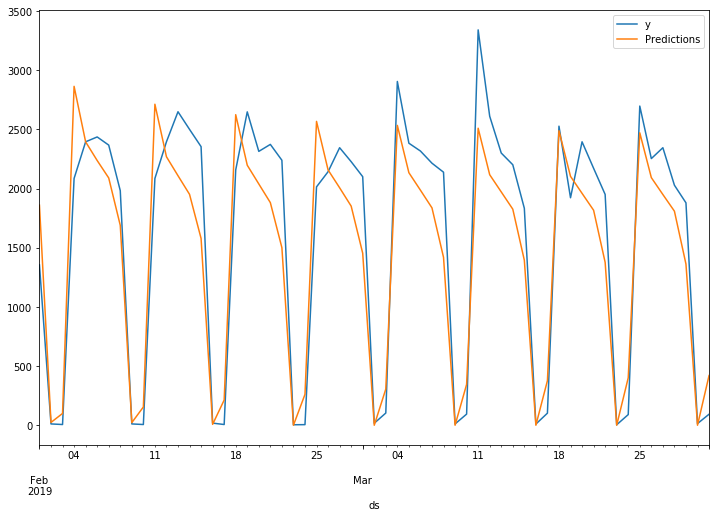

In [63]:
df_test.plot(figsize=(12,8));